# Работа с данными. Домашнее задание


## Задача
Имеется набор данных покупателей супермаркета. Проведите анализ и очистку этих данных.

### Описание данных

Дан файл Mall_Customers.csv, содержащий следующие данные по покупателям сети супермаркетов:
- CustomerID — идентификатор покупателя.
- Genre – пол покупателя.
- Age – возраст покупателя.
- Annual Income (k\$) – годовой доход покупателя, тысяч $.
- Spending Score (1–100) – рейтинг покупателя, целевая переменная.

### Задание 1

Загрузите данные из файла `Mall_Customers.csv` в ноутбук и выведите первые пять строк на экран.

In [53]:
import pandas as pd

df = pd.read_csv('Mall_Customers.csv').drop('CustomerID', axis=1)
df.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19.0,15.0,39
1,Male,NaN,NaN,81
2,Female,NaN,16.0,6
3,Female,23.0,16.0,77
4,Female,31.0,17.0,40


### Задание 2

Проведите разведочный анализ загруженных данных. Обязательные атрибуты для анализа:
- количество пропусков в каждом признаке;
- распределения признаков;
- возможные выбросы или аномалии.

Анализ дополнительных атрибутов и свойств данных приветствуется. Используйте средства визуализации там, где это необходимо.

По результатам анализа сделайте выводы о свойствах отдельных признаков и качестве данных в целом.

In [54]:
df.shape

(200, 4)

In [55]:
df.isna().sum()


Genre                     19
Age                       20
Annual Income (k$)        20
Spending Score (1-100)     0
dtype: int64

In [56]:
# % пропущенных значений 
df.isna().sum() / df.shape[0] * 100

Genre                      9.5
Age                       10.0
Annual Income (k$)        10.0
Spending Score (1-100)     0.0
dtype: float64

**Вывод:**
Ни один из признаков мы не можем удалить, так как количество пропусков не превышает 10%.

In [57]:
df_miss_row = df[df.isna().sum(axis=1) >= 2]
df_miss_row.head(df_miss_row.shape[0])

,Genre,Age,Annual Income (k$),Spending Score (1-100)
1,Male,NaN,NaN,81
46,Female,NaN,NaN,55
54,NaN,50.0,NaN,45
106,NaN,NaN,63.0,50
123,NaN,39.0,NaN,91


In [58]:
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Age,180.0,39.89,16.84,18.0,29.00,36.0,49.0,135.0
Annual Income (k$),180.0,5615.43,74531.12,15.0,42.00,61.0,78.0,1000000.0
Spending Score (1-100),200.0,50.20,25.82,1.0,34.75,50.0,73.0,99.0


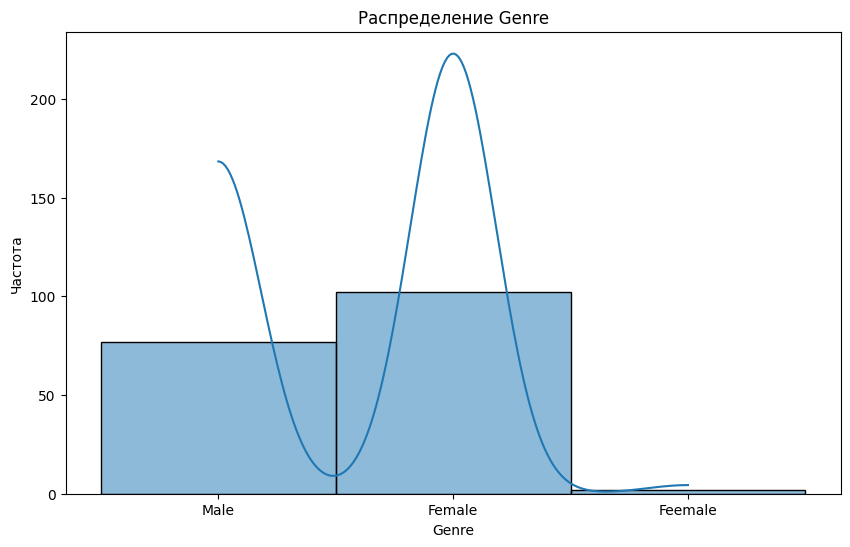

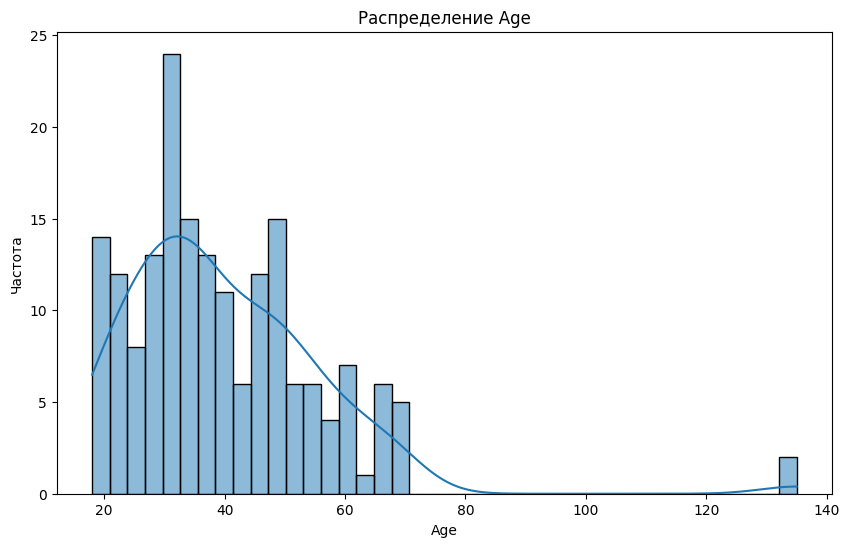

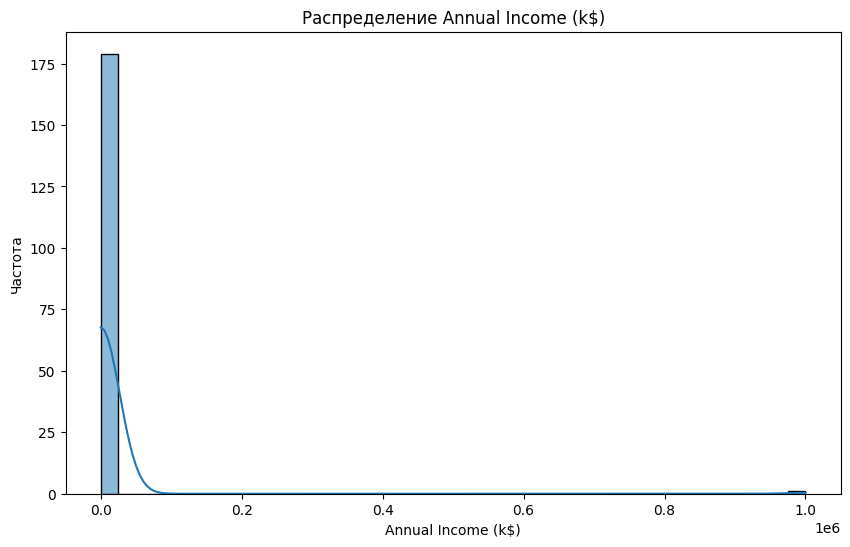

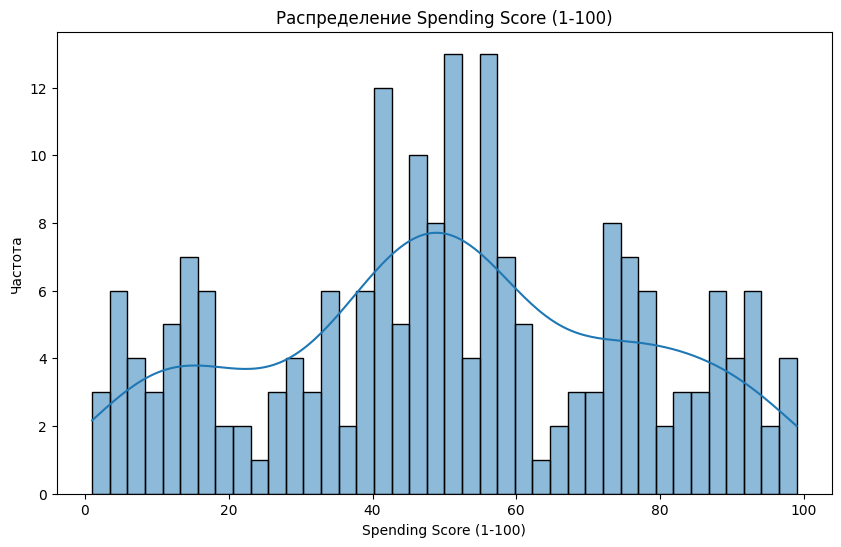

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

for column in df.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], bins=40, kde=True)
    plt.title(f'Распределение {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()

**Выводы:** Есть выбросы в признаках *Age* и *Annual Income (k$)*

In [41]:
out_params = ['Age', 'Annual Income (k$)']
for param in out_params:
    Q1 = df[param].quantile(0.25)
    Q3 = df[param].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print(f'Lower bound: {lower_bound}')
    print(f'Upper bound: {upper_bound}')


    # Удаление выбросов
    df = df[(df[param] >= lower_bound) & (df[param] <= upper_bound)]

Lower bound: -1.0
Upper bound: 79.0
Lower bound: -7.625
Upper bound: 129.375


In [11]:
df['Annual Income (k$)'].describe()

count        180.000000
mean        5615.433333
std        74531.115872
min           15.000000
25%           42.000000
50%           61.000000
75%           78.000000
max      1000000.000000
Name: Annual Income (k$), dtype: float64

### Задание 3

Разделите данные на обучающую и тестовую выборки в пропорции 80:20. Здесь и далее используйте random_state = 1.

In [ ]:
### YOUR CODE HERE ###


### Задание 4

Заполните пропуски в признаках в обучающей выборке с использованием инструментов sklearn. Для каждого признака выберите и аргументируйте стратегию заполнения пропусков.

In [ ]:
### YOUR CODE HERE ###


### Задание 5

Найдите выбросы в признаках обучающей выборки. Замените выбросы, если таковые имеются, и аргументируйте выбор метода поиска выбросов.


In [ ]:
### YOUR CODE HERE ###


### Задание 6

Нормализуйте численные признаки. Аргументируйте выбор стратегии нормализации для каждого признака.


In [ ]:
### YOUR CODE HERE ###


### Задание 7

Закодируйте категориальные признаки в обучающей выборке. Аргументируйте выбор способа кодирования.

In [ ]:
### YOUR CODE HERE ###


### Задание 8
Проведите очистку и подготовку тестовых данных. Используйте препроцессоры и другие инструменты, которые вы уже использовали при подготовке обучающей выборки, без их дополнительной настройки.

In [ ]:
### YOUR CODE HERE ###
